In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

# Reshape images to include a channel dimension (for CNN)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Convert labels to categorical one-hot encoding
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [3]:
# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

c:\Users\Hrishikesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Define training parameters
batch_size = 128
epochs = 15

# Train the model
history = model.fit(
    train_images, 
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1
)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.7646 - loss: 0.7548 - val_accuracy: 0.9788 - val_loss: 0.0827
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9627 - loss: 0.1208 - val_accuracy: 0.9838 - val_loss: 0.0602
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9732 - loss: 0.0863 - val_accuracy: 0.9873 - val_loss: 0.0503
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9784 - loss: 0.0701 - val_accuracy: 0.9883 - val_loss: 0.0422
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9812 - loss: 0.0606 - val_accuracy: 0.9887 - val_loss: 0.0379
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9831 - loss: 0.0535 - val_accuracy: 0.9903 - val_loss: 0.0372
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9838 - loss: 0.0511 - val_accuracy: 0.9900 - val_loss: 0.0360
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.9842 - loss: 0.0485 - 

Test loss: 0.0239
Test accuracy: 0.9917


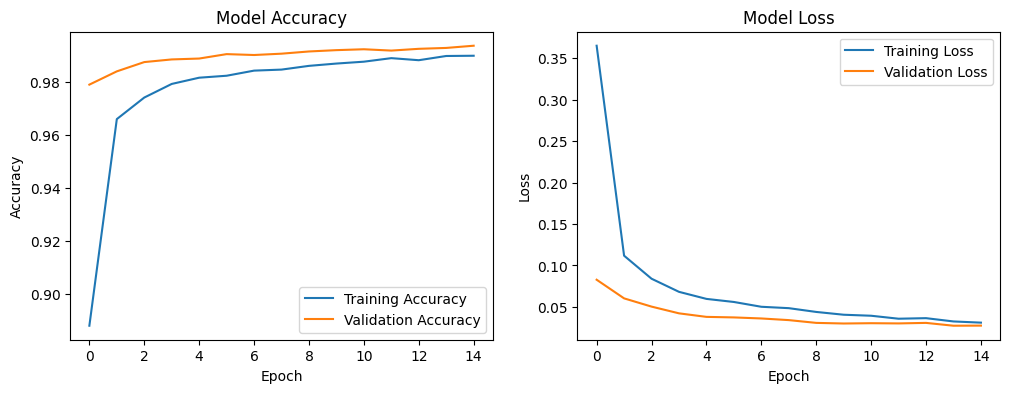

In [5]:
# Evaluate on test data
score = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test loss: {score[0]:.4f}")
print(f"Test accuracy: {score[1]:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [6]:
# Save the model
model.save("mnist_digit_recognizer.h5")

# Load the model later
# loaded_model = keras.models.load_model("mnist_digit_recognizer.h5")

In [8]:
from flask import Flask, request, jsonify, render_template_string
from tensorflow import keras
from PIL import Image
import numpy as np
import io
import base64
import re
import os

# Initialize Flask app
app = Flask(__name__)

# Load the pre-trained model
try:
    model = keras.models.load_model('mnist_digit_recognizer.h5')
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400
    
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected'}), 400
    
    try:
        # Read and preprocess image
        img = Image.open(io.BytesIO(file.read()))
        img = img.convert('L').resize((28, 28))
        img_array = np.array(img).reshape(1, 28, 28, 1).astype('float32') / 255.0
        
        # Make prediction
        pred = model.predict(img_array)
        
        return jsonify({
            'prediction': int(np.argmax(pred)),
            'confidence': float(np.max(pred)) * 100
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 500